In [3]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

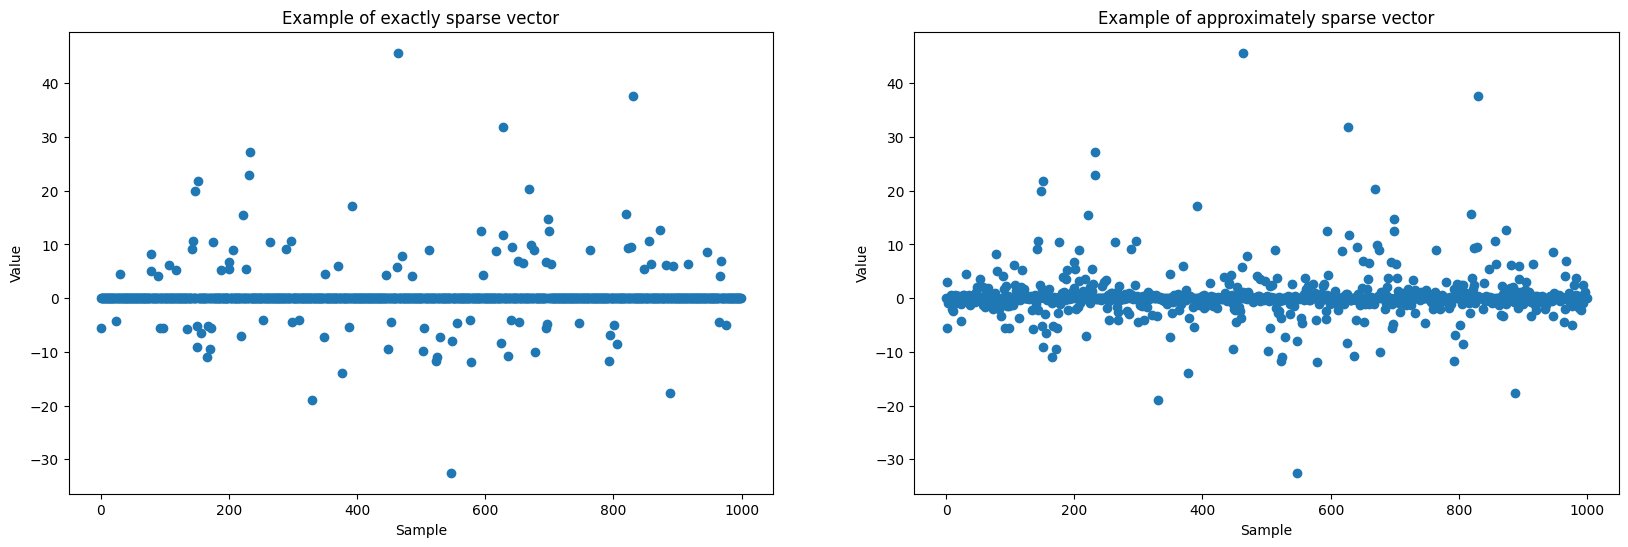

In [4]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

The distinction between exactly sparse and approximately sparse signals is central in signal processing and compressed sensing. Here are the definitions and the key difference:

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

The cross shape in the scatter plot of the first two sources from matrix S comes from how these sources are created. They are generated from a uniform distribution that's been adjusted with a power transformation. This setup makes it more likely for samples to have lower values in both sources. As a result, it's less likely for samples to have high values in both sources at the same time. This creates a pattern where samples tend to cluster around the lower values of one source or the other, forming the arms of the cross. The cross shape is due to the distribution favoring lower values and the power transformation applied to the data.

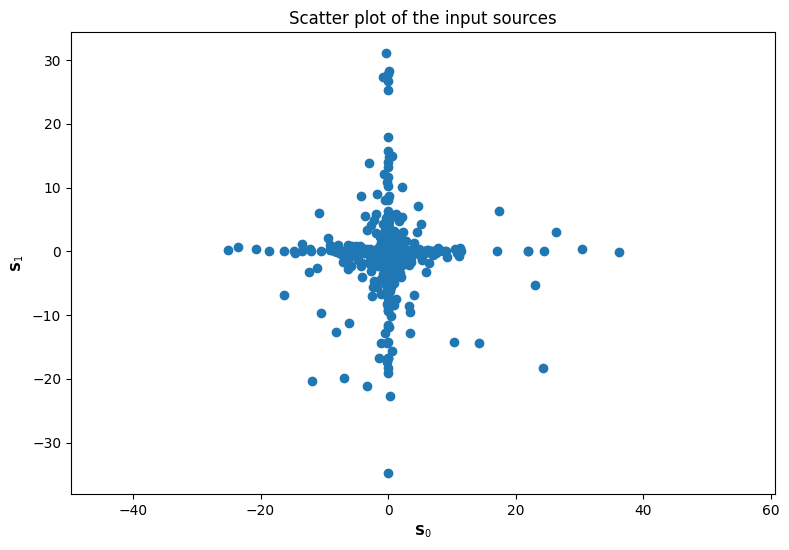

In [7]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix.
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse
# law we used above.
S = np.random.randn(n, t) ** power

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [12]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing.
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120:
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ?

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?

In the scatter plot of X, which shows the endmembers A multiplied by their abundances S, you can see a cross shape that's rotated and skewed. This cross shape, originally vertical and horizontal in S, now appears at an angle that can change depending on different versions of A.

The new directions of the cross match the columns of A, each showing the weight of a particular source. These directions represent the main axes of the transformed data, showing where the data varies the most.

Changing A means adjusting the mix of different sources, leading to different patterns in the scatter plot of S and different angles in the scatter plot of X. Adjusting the noise level affects how well we can see the true signal; more noise makes it harder to separate the sources. This increased noise spreads the points further from the ideal lines in the scatter plot.

Changing the power parameter affects how the original sources are distributed. A higher power value makes the source signals more spread out, which can change the shape and features of the scatter plot, especially considering how the endmember spectra are distributed in the hyperspectral image. Also, using even values for the power parameter can turn the star-shaped scatter plot into an L-shape. This change shows how sensitive the data is to the power parameter, highlighting its role in shaping the scatter plot patterns.

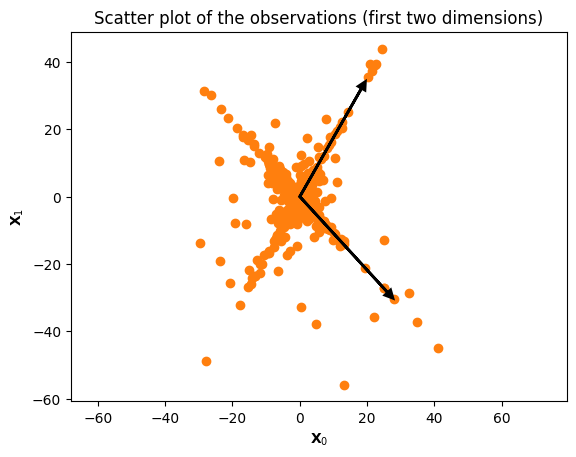

In [13]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

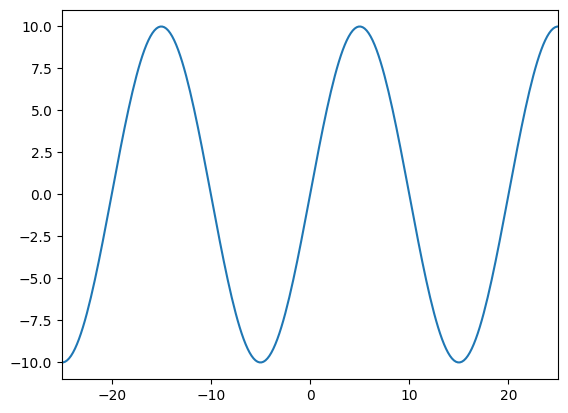

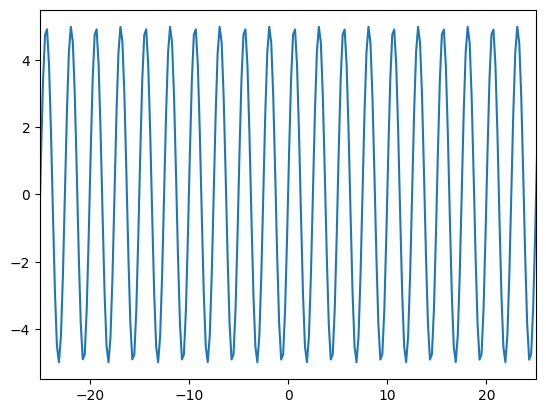

In [14]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

The Discrete Cosine Transform (DCT) is used in many areas to change data from its original form into a frequency-based form. This helps with tasks like compressing data, pulling out important features, and processing signals or images. The DCT makes data compression more efficient by focusing the signal's energy into fewer components. It's also useful for reducing noise, filtering, and extracting features, making it a handy tool for many applications.

When using the DCT, signals are broken down into their different frequencies. If the original signals are pure sinusoids, each with just one frequency, plotting the absolute values of the DCT will show peaks at these frequencies. However, because real sine waves are finite, other non-zero frequencies can appear. So, while the main peaks show the main frequencies in the signals, smaller peaks might also show up because of how the transformation works.

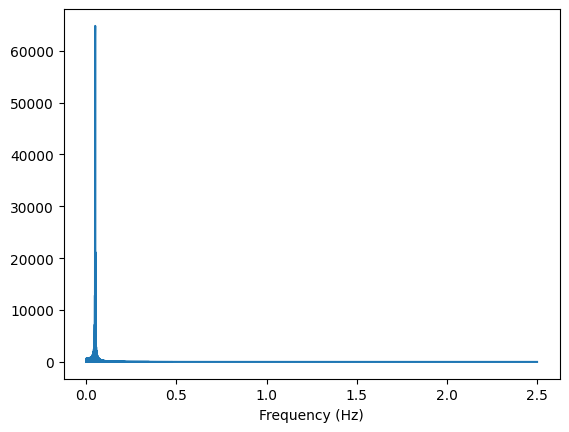

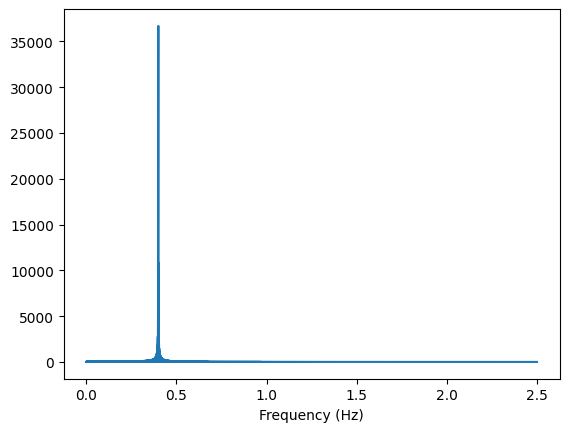

In [18]:
# Transformation into the DCT domain
Sf = sff.dct(S)

dt = (np.max(x_abs) - np.min(x_abs)) / len(x_abs)  # Sampling period
T = dt * len(x_abs)  # Duration
nyquist = (len(x_abs) / 2) / T

# Plotting the absolute value of the DCT
plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(Sf[0, :]))
plt.xlabel("Frequency (Hz)")
plt.plot()
plt.show()

plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(Sf[1, :]))
plt.xlabel("Frequency (Hz)")
plt.show()


Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

The DCT of X shows peaks at the same frequencies as the original signals, reflecting the frequencies in the sources S. However, because of mixing and added noise, these peaks are less clear than in the DCT of the original signals. There are also small peaks at other frequencies due to noise.

Since the DCT keeps peaks at the original frequencies, it helps in recovering the sources. The DCT separates signals by their frequency, so identifying important frequencies allows for better source separation. By finding and isolating these frequencies, the DCT helps recover the original sources from the mixed signals.

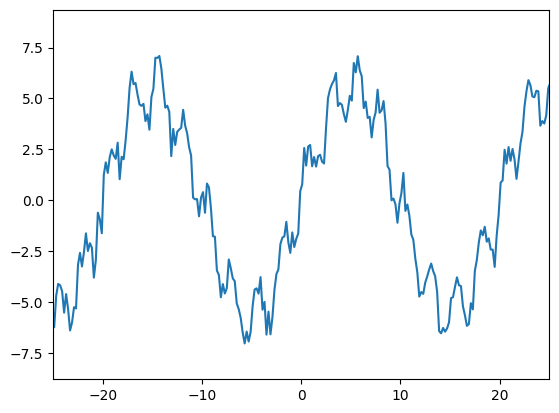

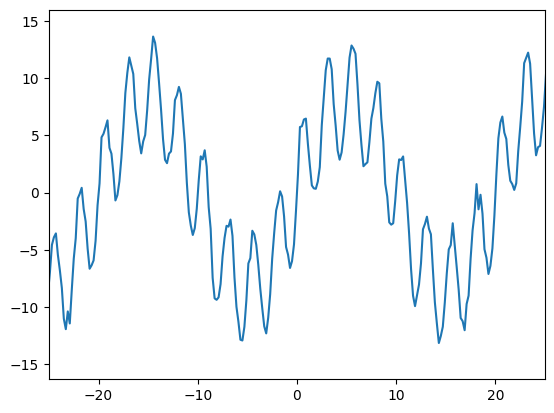

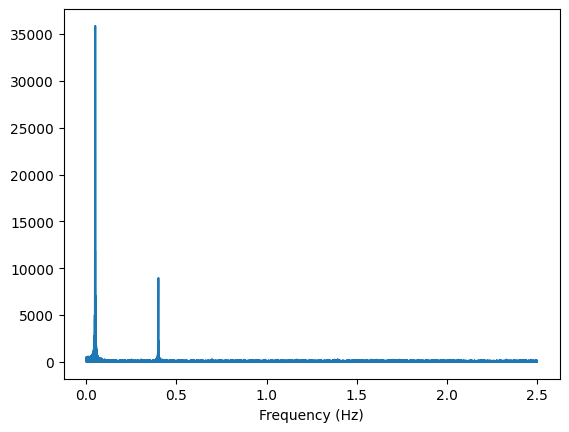

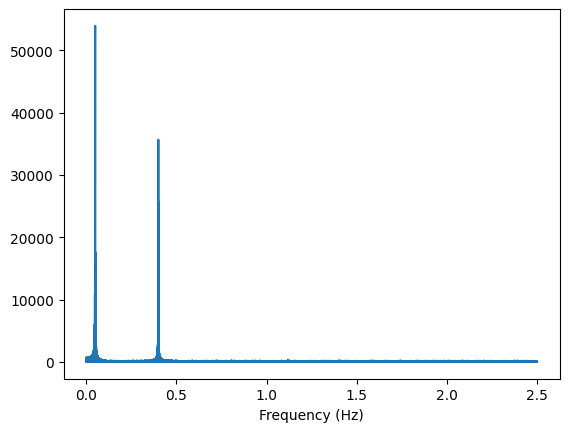

In [19]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

Xf = sff.dct(X)

# Plotting mixtures
plt.figure()
plt.plot(x_abs, X[0, :])
plt.xlim([-25, 25])

plt.figure()
plt.plot(x_abs, X[1, :])
plt.xlim([-25, 25])


# Plotting the absolute value of the DCT
plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(Xf[0, :]))
plt.xlabel("Frequency (Hz)")
plt.show()

plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(Xf[1, :]))
plt.xlabel("Frequency (Hz)")
plt.show()

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


Compute the gradient along the S variable of the data-fidelity term.

Recall what the proximal operator of the l1-norm is.

### Sparse Source Separation — Cost Function and Key Components

We consider the linear model:

$$
X = A S
$$

where:
- $ X \in \mathbb{R}^{m \times t} $: observed signals,
- $ A \in \mathbb{R}^{m \times n} $: known mixing matrix,
- $ S \in \mathbb{R}^{n \times t} $: source matrix to be estimated.

To recover \( S \), we formulate an optimization problem combining a reconstruction objective and a sparsity constraint.

---

### Cost Function

We aim to minimize the following objective:

$$
\min_S \ \frac{1}{2} \| X - A S \|_F^2 + \lambda \| S \|_1
$$

This expression has two main components:

#### Data Fidelity Term:

$$
\frac{1}{2} \| X - A S \|_F^2
$$

This term quantifies the discrepancy between the observed data $ X $ and the estimate $ A S $. It ensures that the recovered sources, when mixed through $ A $, closely approximate the observations.  
This function is smooth and convex, owing to the squared Frobenius norm. It admits a unique minimum and supports gradient-based optimization.

#### Sparsity Term:

$$
\lambda \| S \|_1
$$

This term imposes a sparsity prior on \( S \) by penalizing the sum of the absolute values of its entries. The regularization parameter \( \lambda > 0 \) controls the strength of the penalty.  
Although non-smooth due to the absolute value, this term is convex. It promotes solutions where most components of \( S \) are zero, reflecting the assumption of sparse sources.

---

### Convexity

Both the data fidelity and sparsity terms are convex. Hence, the overall cost function is convex. This guarantees that any local minimum is also a global minimum.

---

### Gradient of the Data Fidelity Term

We compute the gradient of the smooth part with respect to \( S \):

Let:

$$
f(S) = \frac{1}{2} \| X - A S \|_F^2
$$

Then:

$$
\nabla_S f(S) = A^\top (A S - X) = A^\top A S - A^\top X
$$

This gradient is used in the gradient descent step of the ISTA algorithm.

---

### Proximal Operator of the $ \ell_1 $-Norm

The proximal operator associated with the $ \ell_1 $-norm is the **soft-thresholding operator**, which operates elementwise on a matrix $ Z \in \mathbb{R}^{n \times t} $.

For a scalar $ z \in \mathbb{R} $, the soft-thresholding function is defined as:

$$
\text{SoftThreshold}(z, \lambda) =
\begin{cases}
z - \lambda & \text{if } z > \lambda \\
z + \lambda & \text{if } z < -\lambda \\
0 & \text{if } |z| \leq \lambda
\end{cases}
$$

Applied elementwise, this operator shrinks coefficients towards zero and sets small values exactly to zero, effectively enforcing sparsity.

---


In [20]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est, thrd):
    S_est = np.sign(S_est) * np.maximum(np.abs(S_est) - thrd, 0)
    return S_est



Explain the main idea of the ISTA algorithm. Then, implement it.

The Iterative Shrinkage-Thresholding Algorithm (ISTA) is a strong method used to solve certain types of optimization problems. These problems usually involve a smooth, convex function combined with a non-smooth, convex penalty.

ISTA works by iteratively estimating a sparse representation of a signal. It does this through repeated steps of thresholding and shrinking. This approach is especially useful in areas like compressed sensing or sparse regression, where finding a sparse signal representation is important.

In [21]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X, A=np.eye(2), n=2, lamb=0, nbIt=100):
    S_est = np.zeros((A.shape[1], X.shape[1]))
    gamma = 0.9 / np.linalg.norm(A.T @ A)
    for index in range(nbIt):
        S_est = prox_l1(S_est - gamma * (A.T @ (A @ S_est - X)), lamb)
    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

It's important to keep the regularization parameter greater than 0. If it's 0 or negative, the regularization term in the cost function won't work as intended. Instead of helping to create a sparse solution, it could lead to a denser one, which isn't what we want for sparse signal recovery.

On the other hand, if the regularization parameter is too large, the algorithm might focus too much on sparsity and not enough on fitting the data well. This can cause underfitting, where the model doesn't capture the real signal in the data. In extreme cases, if the parameter is extremely large, the solution might become too sparse, maybe even all zeros, and won't fit the data well.

In [33]:
S_estf = ISTA(Xf,A = A,n=2,lamb=5000,nbIt = 1000)



Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

When we plot the estimated sources in the DCT domain and look at the amplitude values near the peaks, we see that the sources are approximately sparse. This means that most of the signal's energy is concentrated in a few coefficients, which correspond to the frequencies of the sinusoids in the original signals. The other coefficients have values close to zero, showing that they don't contribute much to the overall signal. This shows the sparse nature of the sources, where only a few coefficients have important information, and the rest are almost negligible.

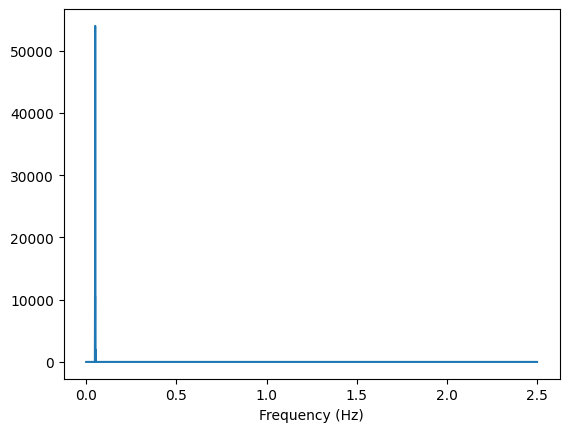

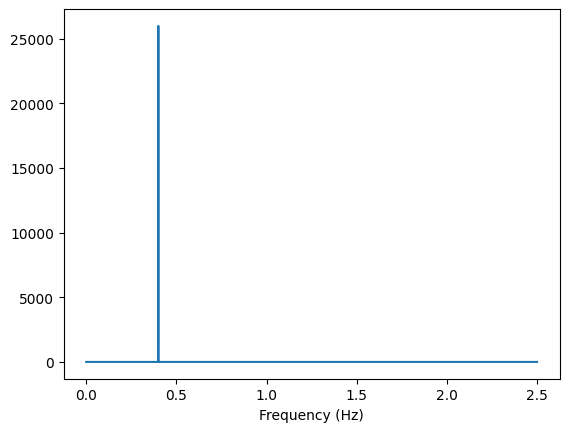

In [34]:
plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(S_estf[0, :]) )
plt.xlabel("Frequency (Hz)")
plt.show()

plt.figure()
plt.plot(np.linspace(0, nyquist, len(x_abs)), abs(S_estf[1, :]) )
plt.xlabel("Frequency (Hz)")
plt.show()



Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

The estimated sources look similar to the original ones in terms of overall shape and structure, which are sinusoidal. However, we can notice a phase shift between the original and estimated signals.

This phase shift is common in source separation problems. Since the algorithm only sees mixed signals and not the original alignment of the sources, it can recover the sources only up to a phase shift or permutation.

The important point is that the main patterns and periodic structure of the sources are preserved. If we know the original signals are periodic with certain frequencies, we can use that information to correct the phase shift and improve the final result.


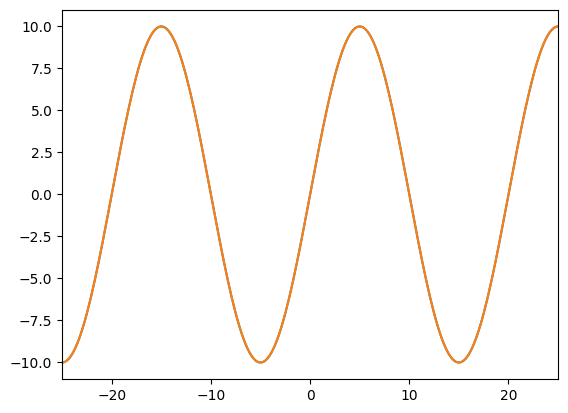

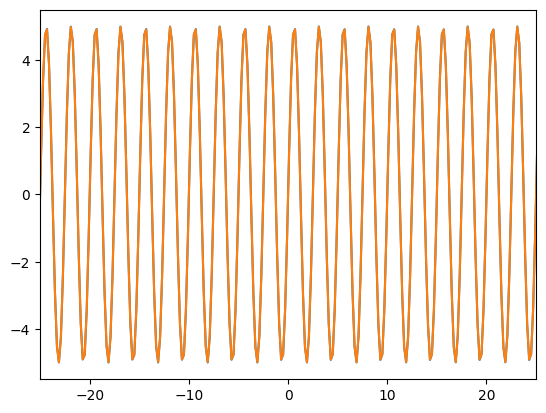

In [35]:
S_dir = sff.idct(S_estf)

plt.figure()
plt.plot(x_abs, S_dir[0] * S[0].max() / S_dir[0].max())
plt.plot(x_abs, S[0])
plt.xlim([-25, 25])
plt.show()

plt.figure()
plt.plot(x_abs, S_dir[1] * S[1].max() / S_dir[1].max())
plt.plot(x_abs, S[1])
plt.xlim([-25, 25])
plt.show()

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




Recall what the gradient of the data fidelity term over A is.

Compte the proximal operator of the oblique constraint. Implement it.

### Cost Function

We minimize the following objective:

$$
\min_{A, S} \ \frac{1}{2} \| X - A S \|_F^2 + \lambda \| S \|_1 + \iota_{\mathcal{O}}(A)
$$

Where:

- $ \frac{1}{2} \| X - A S \|_F^2 $ is the **data fidelity term**  
  → smooth and convex in $ A $ or $ S $ (when the other is fixed)

- $ \lambda \| S \|_1 $ is the **sparsity-inducing term**  
  → convex but non-smooth

- $ \iota_{\mathcal{O}}(A) $ is the **indicator function** of the oblique set  
  $ \mathcal{O} = \{ A \in \mathbb{R}^{m \times n} \mid \| A_{:,j} \|_2 = 1 \ \forall j \} $  
  → non-convex, enforces unit-norm columns in $A$

This formulation separates the smooth and non-smooth parts, allowing the use of proximal algorithms.

**Overall**, the problem is **non-convex** due to:
- the bilinear term $ A S $
- the non-convex constraint $ A \in \mathcal{O} $

---

### Gradient w.r.t. $ A $

The gradient of the fidelity term with respect to $ A $ is:

$$
\nabla_A \left( \frac{1}{2} \| X - A S \|_F^2 \right) = (A S - X) S^\top
$$

---

### Proximal Operator of $ \iota_{\mathcal{O}} $

The proximal operator of the indicator function is the **projection** onto the constraint set $ \mathcal{O} $:

$$
\text{prox}_{\iota_{\mathcal{O}}}(A) = \underset{B \in \mathcal{O}}{\arg\min} \ \| B - A \|_F^2
= \left[ \frac{A_{:,1}}{\| A_{:,1} \|_2}, \ \frac{A_{:,2}}{\| A_{:,2} \|_2}, \ \dots, \ \frac{A_{:,n}}{\| A_{:,n} \|_2} \right]
$$





In [36]:
sdef prox_oblique(A):
    for j in range(A.shape[1]):
        A[:, j] /= max(1, np.linalg.norm(A[:, j]))
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [39]:
def PALM(X, n=2, lamb=0, nbIt=100):
    S_est = np.zeros((n, X.shape[1]))
    A_est = np.eye(X.shape[0], n)
    for i in range(nbIt):
        S_est = prox_l1(
            S_est
            + (0.9 / (np.linalg.norm(A_est.T @ A_est) + np.nextafter(0, 1)))
            * (np.dot(A_est.T, (X - np.dot(A_est, S_est)))),
            lamb,
        )
        A_est = prox_oblique(
            A_est
            + (0.9 / (np.linalg.norm(S_est @ S_est.T) + np.nextafter(0, 1)))
            * np.dot((X - np.dot(A_est, S_est)), S_est.T)
        )

    return A_est, S_est


Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

When we look at the true and estimated sources, it's clear that the separation quality is very high. The estimated sources are very similar to the originals, with almost no differences in scale, phase shifts, or order. While there's a slight phase shift, it's much smaller than what we see in non-blind source separation.

Additionally, when we compare the true and estimated mixing matrices, they are very similar. This shows that the PALM algorithm is effective at "unmixing" the sources from the observed data. This similarity highlights the algorithm's success in accurately recovering the mixing process, further confirming the accuracy of the source separation results.

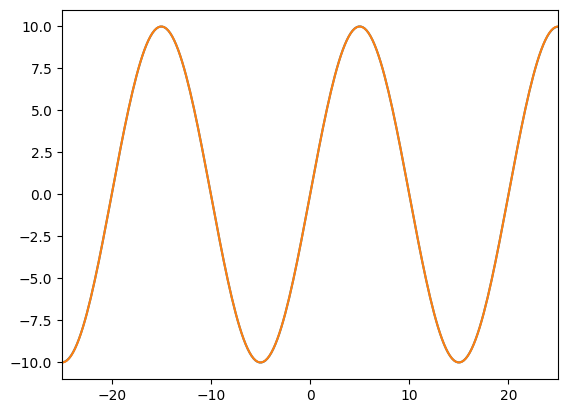

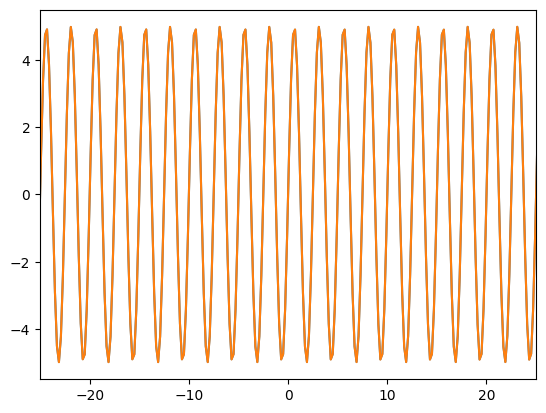

In [41]:
A_est, S_est = PALM(Xf, n=2, lamb=1000, nbIt=1000)
S_dir = sff.idct(S_est)

plt.figure()
plt.plot(x_abs, S_dir[0] * S[0].max() / S_dir[0].max())
plt.plot(x_abs, S[0])
plt.xlim([-25, 25])
plt.show()

plt.figure()
plt.plot(x_abs, S_dir[1] * S[1].max() / S_dir[1].max())
plt.plot(x_abs, S[1])
plt.xlim([-25, 25])
plt.show()

In [43]:
print("Matrix A:\n", A)
print("Matrix A_est:\n", A_est)
print("diff :", A - A_est)



Matrix A:
 [[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
Matrix A_est:
 [[0.55454198 0.24405453]
 [0.83215575 0.96976151]]
diff : [[ 0.00015822 -0.0015189 ]
 [-0.00010546  0.00038099]]
